<a href="https://colab.research.google.com/github/RajezMariner/Deep_Learning/blob/master/Exercise_LSTM_Amazon_food.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
sqlite_path = "/content/drive/My Drive/database.sqlite"
con = sqlite3.connect(sqlite_path)

In [4]:
filtered_data = pd.read_sql_query(""" SELECT * FROM reviews WHERE Score != 3 LIMIT 500000""", con) 

In [5]:
filtered_data.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [6]:
# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (500000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [7]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [8]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [9]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [10]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [11]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(348262, 10)

In [12]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.6524

In [13]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [14]:

#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(348260, 10)


1    293516
0     54744
Name: Score, dtype: int64

In [15]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I am not a huge fan of Lipton teas in general, but this variety struck my fancy - the traditional green tea with passionfruit, orange, and jasmine.  I compared it side-by-side with the plain green tea from Lipton and there is a very noticeable difference.  This variety is less harsh and bitter, more smooth and engaging.  It's great when tea has a bit of a fruity taste to it (Earl Grey is the prime example) and this tea definitely pulls it off.  True, it's not quite on the level of other gourmet teas (hence the 4 stars), but for the price, you would be hard-pressed to find a better value.  Highly recommended for green

In [16]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [17]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I am not a huge fan of Lipton teas in general, but this variety struck my fancy - the traditional green tea with passionfruit, orange, and jasmine.  I compared it side-by-side with the plain green tea from Lipton and there is a very noticeable difference.  This variety is less harsh and bitter, more smooth and engaging.  It's great when tea has a bit of a fruity taste to it (Earl Grey is the prime example) and this tea definitely pulls it off.  True, it's not quite on the level of other gourmet teas (hence the 4 stars), but for the price, you would be hard-pressed to find a better value.  Highly recommended for green

In [18]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [19]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

I love tea, but I am VERY picky about the kind I will drink.  MarketSpice is blend is by far one of my favorites.  In fact...I need to go get some more...I am out!


In [20]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [21]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

I love tea but I am VERY picky about the kind I will drink MarketSpice is blend is by far one of my favorites In fact I need to go get some more I am out 


In [22]:
stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [23]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 348260/348260 [01:42<00:00, 3404.17it/s]


In [24]:
preprocessed_reviews[1500]

'love tea picky kind drink marketspice blend far one favorites fact need go get'

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc
from sklearn import model_selection

#Data undergoes the process of the bag of words into two sets: a) train data and b) test data
#Let us split the data into two categories. and fit into different

def split_data(final_data,total_data):
    X_tr,Y_test,X_sc,Y_sc= train_test_split(final_data['preprocessed_reviews'][:total_data],final_data['final_result'][:total_data],test_size=0.2,random_state=0,shuffle=False)
    train_review,cv_review,train_score,cv_score = train_test_split(X_tr,X_sc,test_size=0.15,random_state=0)
    
    print('test review size', len(Y_test))
    print('test score size', len(Y_sc))
    
    print('train review size : ',len(train_review))
    print('train score size : ',len(train_score))
    
    print('cv review size : ',len(cv_review))
    print('cv score size : ',len(cv_score))
    
    return X_tr, Y_test, X_sc, Y_sc, train_review, cv_review, train_score, cv_score

In [26]:
final = final.reset_index()

In [27]:
pos_data = []
neg_data = []

pos_score = []
neg_score = []

data_set = []
score = []

pos_count = 0
neg_count = 0
for i in range(len(preprocessed_reviews)):
    if final['Score'][i] == 1 and pos_count <= 50000:
        pos_count += 1
        pos_data.append(preprocessed_reviews[i])
        pos_score.append(final['Score'][i])
    elif final['Score'][i] == 0 and neg_count <= 50000:
        neg_count += 1
        neg_data.append(preprocessed_reviews[i])
        neg_score.append(final['Score'][i])

In [28]:
data_set.extend(pos_data)
data_set.extend(neg_data)

score.extend(pos_score)
score.extend(neg_score)

In [29]:
train_review = []
cv_review = []
train_score = []
cv_score = []
X_tr = []
Y_test = []
X_sc = []
Y_sc = []

for i in range(0,35000):
 train_review.append(pos_data[i])
 train_review.append(neg_data[i])
 train_score.append(pos_score[i])
 train_score.append(neg_score[i])

for i in range(35001,50000):
 cv_review.append(pos_data[i])
 cv_review.append(neg_data[i])
 cv_score.append(pos_score[i])
 cv_score.append(neg_score[i])

X_tr.extend(train_review)
X_tr.extend(cv_review)
X_sc.extend(train_score)
X_sc.extend(cv_score)

In [30]:
from nltk import word_tokenize
train_word_counts = {}
test_word_counts = {}

In [31]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [32]:
from tqdm import tqdm

In [33]:
def update_word_count(d, r):
  for word in tqdm(r):
    for token in word_tokenize(word):
      if token in d:
        d[token] +=1
      else:
        d[token] = 1

In [34]:
update_word_count(train_word_counts, train_review)

100%|██████████| 70000/70000 [00:15<00:00, 4598.49it/s]


In [35]:
# update_word_count(test_word_counts, cv_review)

100%|██████████| 29998/29998 [00:07<00:00, 4265.75it/s]


In [35]:
def sort_dict(r):
  orders = sorted(r.items(), key=lambda x: x[1], reverse=True)
  return orders, [o[0] for o in orders]

In [36]:
train_order_counts, train_order = sort_dict(train_word_counts)
# test_order_counts, test_order = sort_dict(test_word_counts)

In [37]:
len(train_order)

51623

In [38]:
def update_indexed(l, wc, threshold):
  t_index = []
  for x in l:
    z = []
    for y in word_tokenize(x):
      try:
        i = wc.index(y)+1
        if i < threshold:
          z.append(i)
      except:
        continue
    t_index.append(z)
  return t_index

index_threshold=10000
train_indexed = update_indexed(train_review, train_order, index_threshold)
test_indexed = update_indexed(cv_review, train_order, index_threshold)

In [39]:
# Credits: https://machinelearningmastery.com/sequence-classification-lstm-recurrent-neural-networks-python-keras/
# LSTM for sequence classification in the IMDB dataset
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
# fix random seed for reproducibility
np.random.seed(7)

Using TensorFlow backend.


In [40]:
# truncate and/or pad input sequences
max_review_length = 600
X_train = sequence.pad_sequences(train_indexed, maxlen=max_review_length)
X_test = sequence.pad_sequences(test_indexed, maxlen=max_review_length)

print(X_train.shape)
# print(X_train[1])

(70000, 600)


In [75]:
del model

In [76]:
# create the model
top_words=5000
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(top_words+1, embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
#Refer: https://datascience.stackexchange.com/questions/10615/number-of-parameters-in-an-lstm-model

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 600, 32)           160032    
_________________________________________________________________
lstm_16 (LSTM)               (None, 100)               53200     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 101       
Total params: 213,333
Trainable params: 213,333
Non-trainable params: 0
_________________________________________________________________
None


In [55]:
#Preprocessing the train and cv scores.
train_score_array = np.array(train_score)
cv_score_array = np.array(cv_score)

In [77]:
history = model.fit(X_train, train_score_array, nb_epoch=10, batch_size=500, validation_data=(X_test, cv_score_array))
# Final evaluation of the model
scores = model.evaluate(X_test, cv_score_array, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Train on 70000 samples, validate on 29998 samples
Epoch 1/10
70000/70000 [==============================] - 140s 2ms/step - loss: 0.4958 - accuracy: 0.7632 - val_loss: 0.3808 - val_accuracy: 0.8362
Epoch 2/10
70000/70000 [==============================] - 137s 2ms/step - loss: 0.3229 - accuracy: 0.8672 - val_loss: 0.2754 - val_accuracy: 0.8899
Epoch 3/10
70000/70000 [==============================] - 135s 2ms/step - loss: 0.2358 - accuracy: 0.9063 - val_loss: 0.2701 - val_accuracy: 0.8903
Epoch 4/10
70000/70000 [==============================] - 136s 2ms/step - loss: 0.2157 - accuracy: 0.9168 - val_loss: 0.2630 - val_accuracy: 0.8942
Epoch 5/10
70000/70000 [==============================] - 135s 2ms/step - loss: 0.2046 - accuracy: 0.9215 - val_loss: 0.2702 - val_accuracy: 0.8944
Epoch 6/10
70000/70000 [==============================] - 135s 2ms/step - loss: 0.1953 - accuracy: 0.9261 - val_loss: 0.2701 - val_accuracy: 0.8937
Epoch 7/10
70000/70000 [==============================] - 139s

In [48]:
history.history.keys()

dict_keys(['loss', 'accuracy'])

In [78]:
%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
import time
def plt_dynamic(x, vy, ty, ax, colors=['b']):
  ax.plot(x, vy, 'b', label="Validation Loss")
  ax.plot(x, ty, 'r', label="Train Loss")
  plt.legend()
  plt.grid()
  fig.canvas.draw()
  # plt.show()

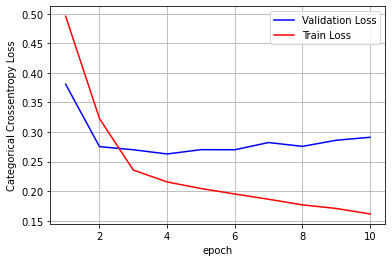

In [80]:
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch')
ax.set_ylabel('Categorical Crossentropy Loss')
# list of epoch numbers
x = list(range(1,10+1))
vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

In [81]:
del model

In [82]:
# create the model
top_words=5000
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(top_words+1, embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(100, return_sequences=True))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 600, 32)           160032    
_________________________________________________________________
lstm_17 (LSTM)               (None, 600, 100)          53200     
_________________________________________________________________
lstm_18 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 101       
Total params: 293,733
Trainable params: 293,733
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
history = model.fit(X_train, train_score_array, nb_epoch=10, batch_size=500, validation_data=(X_test, cv_score_array))
scores = model.evaluate(X_test, cv_score_array, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Train on 70000 samples, validate on 29998 samples
Epoch 1/10
15500/70000 [=====>........................] - ETA: 3:25 - loss: 0.6168 - accuracy: 0.6321

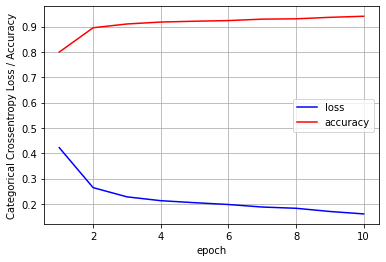

In [61]:
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch')
ax.set_ylabel('Categorical Crossentropy Loss')
# list of epoch numbers
x = list(range(1,10+1))
vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

In [62]:
del model

In [67]:
# create the model
top_words=5000
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(top_words+1, embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(100, return_sequences=True))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(25))
model.add(Dropout(0.25))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 600, 32)           160032    
_________________________________________________________________
lstm_11 (LSTM)               (None, 600, 100)          53200     
_________________________________________________________________
lstm_12 (LSTM)               (None, 600, 50)           30200     
_________________________________________________________________
lstm_13 (LSTM)               (None, 25)                7600      
_________________________________________________________________
dropout_2 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 26        
Total params: 251,058
Trainable params: 251,058
Non-trainable params: 0
________________________________________________

In [68]:
history = model.fit(X_train, train_score_array, nb_epoch=10, batch_size=500, validation_data=(X_test, cv_score_array))
scores = model.evaluate(X_test, cv_score_array, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Epoch 1/10
10000/70000 [===>..........................] - ETA: 1:15 - loss: 0.6924 - accuracy: 0.5055

KeyboardInterrupt: ignored

In [ ]:
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch')
ax.set_ylabel('Categorical Crossentropy Loss')
# list of epoch numbers
x = list(range(1,10+1))
vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)